In [1]:
import networkx as nx
import scipy.sparse as sp
import numpy as np
import utils
import torch
import torch
from collections import defaultdict
import numpy as np
import time
import json

In [2]:
seed=114514
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.seed_all()

# **Read data**

In [3]:
loader = np.load('citeseer.npz')
train_ones = loader['edges']
print(len(train_ones))
print(train_ones[:5])

7358
[[1370  823]
 [  65   63]
 [ 262  247]
 [ 398  308]
 [ 859  383]]


In [4]:
adj_sparse = np.zeros((np.max(train_ones)+1,np.max(train_ones)+1))
for e in train_ones:
    adj_sparse[e[0],e[1]]=1
    adj_sparse[e[1],e[0]]=1
    
adj_sparse = sp.coo_matrix(adj_sparse).tocsr()

lcc = utils.largest_connected_components(adj_sparse)
adj_sparse= adj_sparse[lcc,:][:,lcc]
_N = adj_sparse.shape[0]
print('n',_N)
_Edges=[]
for x in np.column_stack(adj_sparse.nonzero()):
    if not x[0]==x[1]:
        _Edges.append((x[0],x[1]))
_num_of_edges=int(len(_Edges)/2)
print('m',_num_of_edges)

dic=defaultdict(set)
for x in _Edges:
    a1=x[0]
    a2=x[1]
    dic[a1].add(a2)
    dic[a2].add(a1)
    

adj_origin=np.zeros((_N,_N)).astype(int)
for (i,j) in _Edges:
    adj_origin[i][j]=1
    adj_origin[j][i]=1
assert(np.sum(adj_origin==adj_origin.T)==_N*_N)
assert(np.sum(adj_origin)==_num_of_edges*2)

Selecting 1 largest connected components
n 2120
m 3679


# **1.Get link prediction model and embedding**

In [5]:
embedding_dim=128

graphsagemodel=utils.GraphSAGE(_N=_N,_M=_num_of_edges,adj_origin=adj_origin,
                                         adj_dic=dic,embedding_dim=embedding_dim)


# *1.2 Load pretrained model*

In [6]:
graphsagemodel.load_model(path='graphsage.pth',embedding_path='embedding_matrix.pth.npy')

In [7]:
embedding_matrix_numpy=graphsagemodel.embedding_matrix_numpy
link_prediction_model=graphsagemodel.graphsage_link_prediction_from_embedding_one_to_other
predict_adj=utils.evaluate_overlap_torch(_N=_N,
                                                    _num_of_edges=_num_of_edges,
                                                    adj_origin=adj_origin,
                                                    embedding_matrix_numpy=embedding_matrix_numpy,
                                                    link_prediction_from_embedding_one_to_other=link_prediction_model)

2119/2120[(0.80461353, 1185, 1358), (0.8073064, 856, 1223), (0.8060322, 380, 1093), (0.808399, 431, 765), (0.8100257, 603, 1814), (0.80605096, 767, 768), (0.80950147, 14, 765), (0.82261145, 64, 944), (0.8217213, 234, 433), (0.8159603, 413, 1838)]
1.0
(2120, 2120)
7358
7358
True Positve:7046, 0.96
False Positve:312, 0.04
True Negative:4486730, 1.00
False Negative:312, 0.00
Positive:0.00
Negative:1.00


In [8]:
metric_embedding=utils.compute_graph_statistics(predict_adj)
metric_origin=utils.compute_graph_statistics(adj_origin)

Values less than or equal to 0 in data. Throwing out 0 or negative values
/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [9]:
for x in metric_origin:
    print('%-25s origin:%17.8f, link_pred:%17.8f'%(x,metric_origin[x],metric_embedding[x]))

d_max                     origin:      99.00000000, link_pred:      84.00000000
d_min                     origin:       1.00000000, link_pred:       0.00000000
d                         origin:       3.47075472, link_pred:       3.47075472
LCC                       origin:    2120.00000000, link_pred:    2106.00000000
wedge_count               origin:   25974.00000000, link_pred:   23738.00000000
claw_count                origin:  250382.00000000, link_pred:  179041.00000000
triangle_count            origin:    1084.00000000, link_pred:     955.00000000
square_count              origin:     249.00000000, link_pred:     230.00000000
power_law_exp             origin:       2.07078423, link_pred:       2.05032433
gini                      origin:       0.42760979, link_pred:       0.41877035
rel_edge_distr_entropy    origin:       0.95385514, link_pred:       0.95661529
assortativity             origin:       0.00750617, link_pred:      -0.01448289
clustering_coefficient    origin:       

# **2.GAN generate new embeddings**

In [10]:
batch_size=256
noise_dim=16
g_hidden_dim=[32,64,100]
d_hidden_dim=[100,64,32]
lendataloader=20
Diter=5
Giter=1
epoch_numbers=10000
eval_epoch=200


In [11]:
netG = utils.Generator(noise_dim=noise_dim,embedding_dim=embedding_dim, g_hidden_dim=g_hidden_dim,batch_size=batch_size).cuda()

In [12]:
netG.load_state_dict(torch.load('gan_model/bestG.pth'))

<All keys matched successfully>

# *2.2.2compute ECDF*

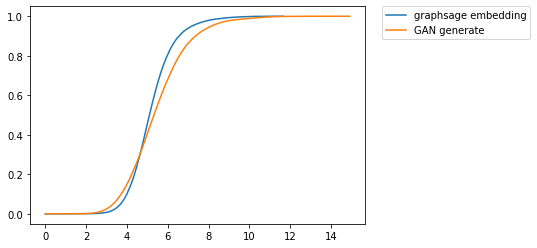

[[1.3090008  0.         0.4011195  0.         0.63684213]
 [1.4057715  0.         0.         0.7536407  0.47576764]
 [0.31215188 0.         0.         0.         0.        ]]
[[1.336173   0.         0.         1.0743436  1.3989782 ]
 [1.5023165  0.         0.         0.4443164  0.27750415]
 [1.8502209  0.         0.01536158 0.55910414 0.3007873 ]]
0.09876162
0.0924415
0.09572865


(0.009607270359992981, 2120)

In [13]:
utils.eval_plot(netG,embedding_matrix=embedding_matrix_numpy,noise_dim=16,mmd_beta=0.1)

# **3.Sample**

In [14]:
def save_graph(adj_generate,dirpath):
    edges=[]
    for i in range(_N):
        for j in range(i+1,_N):
            if adj_generate[i][j]==1:
                edges.append((i,j))
    edges=np.array(edges).astype(int)
    np.save(dirpath,edges)

In [15]:
def edgeoverlap_generate(generate_graph,adj_origin):
    tp=0
    tn=0
    fp=0
    fn=0
    for i in range(_N):
        for j in range(_N):
            if generate_graph[i,j]==1 and adj_origin[i,j]==1:
                tp=tp+1
            if generate_graph[i,j]==0 and adj_origin[i,j]==1:
                fp=fp+1
            if generate_graph[i,j]==1 and adj_origin[i,j]==0:
                fn=fn+1
            if generate_graph[i,j]==0 and adj_origin[i,j]==0:
                tn=tn+1
        print('\r%d/%d'%(i,_N),end="")
    print('\n')
    print('Edge overlap between generate graph and original graph')
    print(generate_graph.shape)
    total_num=_N*_N
    print('True Positve:%d, %.2f'%(tp,tp/(tp+fp)))
    print('False Positve:%d, %.2f'%(fp,fp/(tp+fp)))
    print('True Negative:%d, %.2f'%(tn,tn/(tn+fn)))
    print('False Negative:%d, %.2f'%(fn,fn/(tn+fn)))
    print('Positive:%.2f'%((tp+fp)/total_num))
    print('Negative:%.2f'%((tn+fn)/total_num))
    return tp/(tp+fp)

In [16]:
import os
dirs_generate = 'graph_generate/'
if not os.path.exists(dirs_generate):
    os.makedirs(dirs_generate)
generate_number=5

In [17]:
metric_list={}
for idx in range(generate_number):
    noise= torch.randn(_N, noise_dim).cuda()
    generate_data=netG(noise)
    generate_data=generate_data.detach().to('cpu').numpy()
    print('\n',idx,'\n')
    print(generate_data.shape)
    probability_matrix_generate=utils.generate_probability_matrix(_N,generate_data,
                                                                            link_prediction_model)
    _,graphic_seq_generate=utils.evaluate_overlap_torch_generate(_N,_num_of_edges,
                                                                                      probability_matrix_generate)
    generate_graph=utils.revised_Havel_Hakimmi_Algorithm(_N,_num_of_edges,dic,probability_matrix_generate,graphic_seq_generate)
    
    save_graph(generate_graph,'graph_generate/citeseer_ourmethod'+str(idx))
    data=utils.compute_graph_statistics(generate_graph)
    data['edge_overlap']=edgeoverlap_generate(generate_graph,adj_origin)
    for x in data:
        try:
            metric_list[x]
        except:
            metric_list[x]=[]
        metric_list[x].append(data[x])



 0 

(2120, 128)
2119/2120[(0.9999591112136841, 612, 1855), (0.9999591112136841, 818, 1936), (0.9999594688415527, 871, 1533), (0.9999592304229736, 68, 1340), (0.9999592304229736, 530, 553), (0.9999595880508423, 1716, 1809), (0.9999595880508423, 31, 226), (0.9999593496322632, 102, 1011), (0.9999600648880005, 1017, 1107), (0.9999595880508423, 1319, 2031)]
 max: (1.0, 2090, 2105) min: (0.9999591112136841, 612, 1855)
2120
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[99, 51, 35, 34, 30, 29, 28, 27, 23, 23]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10)]
[(154, 1540), (145, 778), (99, 33), (92, 489), (90, 1011), (78, 1972), (78, 1690), (77, 1786), (76, 2114), (75, 1899)]
[[99, 1540], [51, 778], [35, 33], [34, 489], [30, 1011], [29, 1972], [28, 1690], [27, 1786], [23, 2114], [23, 1899]]
[[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10]]
 remain_edge:0,x=76041347358.0
0.0
3679


/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


2119/2120

Edge overlap between generate graph and original graph
(2120, 2120)
True Positve:12, 0.00
False Positve:7346, 1.00
True Negative:4479696, 1.00
False Negative:7346, 0.00
Positive:0.00
Negative:1.00

 1 

(2120, 128)
2119/2120[(0.9999479055404663, 1444, 1851), (0.9999481439590454, 162, 231), (0.9999488592147827, 1604, 1888), (0.9999488592147827, 772, 934), (0.9999488592147827, 370, 430), (0.9999489784240723, 100, 450), (0.9999489784240723, 435, 1419), (0.9999493360519409, 179, 1452), (0.9999500513076782, 114, 162), (0.9999488592147827, 1247, 1779)]
 max: (1.0, 2008, 2116) min: (0.9999479055404663, 1444, 1851)
2120
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[99, 51, 35, 34, 30, 29, 28, 27, 23, 23]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (0, 8), (0, 9), (0, 10), (0, 14)]
[(137, 1304), (127, 1153), (113, 1785), (113, 100), (103, 1828), (103, 1076), (92, 752), (86, 1036), (77, 176), (75, 112)]
[[99, 1304], [51, 1153], [35, 1785], [34, 100], [30, 1828], [29, 1076], [28, 752], [27, 103

In [18]:
for x in metric_list:
    metric_mean=np.mean(metric_list[x])
    metric_std=np.std(metric_list[x])
    if x=='edge_overlap':
        print('%-22s generate:%16.8f+-%16.8f'%(x,metric_mean,metric_std))
    else:
        print('%-22s origin:%16.8f, link_pred:%16.8f, generate:%16.8f+-%16.8f'%(x,metric_origin[x],
                                                                                metric_embedding[x],metric_mean,metric_std))

d_max                  origin:     99.00000000, link_pred:     84.00000000, generate:     99.00000000+-      0.00000000
d_min                  origin:      1.00000000, link_pred:      0.00000000, generate:      1.00000000+-      0.00000000
d                      origin:      3.47075472, link_pred:      3.47075472, generate:      3.47075472+-      0.00000000
LCC                    origin:   2120.00000000, link_pred:   2106.00000000, generate:   1672.60000000+-     19.54072670
wedge_count            origin:  25974.00000000, link_pred:  23738.00000000, generate:  25974.00000000+-      0.00000000
claw_count             origin: 250382.00000000, link_pred: 179041.00000000, generate: 250382.00000000+-      0.00000000
triangle_count         origin:   1084.00000000, link_pred:    955.00000000, generate:    700.20000000+-     47.76777156
square_count           origin:    249.00000000, link_pred:    230.00000000, generate:    210.40000000+-     71.79582161
power_law_exp          origin:      2.07